In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas.io.data as web

from io import StringIO as io
import os, sys, types
from IPython import get_ipython
from IPython.nbformat import current
from IPython.core.interactiveshell import InteractiveShell

import Quandl
from sklearn.preprocessing import Imputer

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import statsmodels.tsa as tsa
import statsmodels.tsa.api as tpi

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 6)



/Users/AOA/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


In [2]:
# create a pandas dataframe that contains search index data

def create_google_trends_dataframe(csv_file, term_name):
    raw_data = pd.read_csv(csv_file, delimiter=' ')
    
    raw_data_interest = raw_data['interest:']
    interest_column_split = raw_data_interest.apply(lambda x: pd.Series(str(x).split(',')))
    interest_column_split.columns = ['String_Dates', term_name]
    
    frame_slice = interest_column_split[372:607]
    
    # remove old index
    new_index_frame_slice = frame_slice.reset_index(drop=True)
    # create a date index from String_Dates column
    new_index_frame_slice.insert(1, "Date", pd.DatetimeIndex(new_index_frame_slice['String_Dates']).date)
    
    # cast term_name column to float data type
    new_index_frame_slice[term_name] = new_index_frame_slice[term_name].astype(float)
    
    # remove string dates
    new_index_frame_slice.drop('String_Dates', axis=1, inplace=True)
    
    # index by Date column
    google_trends_data = new_index_frame_slice.set_index(new_index_frame_slice['Date'], drop=True)
    google_trends_data.drop('Date', axis=1, inplace=True)
    
    return google_trends_data

In [3]:
bitcoin_val = create_google_trends_dataframe('datasets/bitcoin_value_gtrends.csv', 'bitcoin_value')
bitcoin_price = create_google_trends_dataframe('datasets/bitcoin_price_gtrends.csv', 'bitcoin_price')
btc_mining = create_google_trends_dataframe('datasets/bitcoin_mining_gtrends.csv', 'bitcoin_mining')
mining_bitcoin = create_google_trends_dataframe('datasets/mining_bitcoin.csv', 'mining_bitcoin')
blockchain = create_google_trends_dataframe('datasets/blockchain_gtrends.csv', 'blockchain')
bitcoin_blockchain = create_google_trends_dataframe('datasets/bitcoin_blockchain.csv', 'bitcoin_blockchain')
satoshi_nakamoto = create_google_trends_dataframe('datasets/satoshi_nakamoto.csv', 'satoshi_nakamoto')
bitcoin_usd = create_google_trends_dataframe('datasets/bitcoin_usd.csv', 'bitcoin_usd')
bitcoin_exchange = create_google_trends_dataframe('datasets/bitcoin_exchange.csv', 'bitcoin_exchange')
cryptocurrency = create_google_trends_dataframe('datasets/cryptocurrency_gtrends.csv', 'cryptocurrency')
mt_gox = create_google_trends_dataframe('datasets/mt_gox.csv', 'mt_gox')
silk_road_marketplace = create_google_trends_dataframe('datasets/silk_road_marketplace.csv', 'silk_road_marketplace')
bitcoin_term = create_google_trends_dataframe('datasets/bitcoin_term.csv', 'bitcoin')

In [4]:
combined_data_frame = bitcoin_val.copy()
combined_data_frame['btc_price'] = bitcoin_price['bitcoin_price']
combined_data_frame['btc_mining'] = btc_mining['bitcoin_mining']
combined_data_frame['mining_btc'] = mining_bitcoin['mining_bitcoin']
combined_data_frame['blockchain'] = blockchain['blockchain']
combined_data_frame['btc_blockchain'] = bitcoin_blockchain['bitcoin_blockchain']
combined_data_frame['satoshi_nakamoto'] = satoshi_nakamoto['satoshi_nakamoto']
combined_data_frame['btc_usd'] = bitcoin_usd['bitcoin_usd']
combined_data_frame['btc_exchange'] = bitcoin_exchange['bitcoin_exchange']
combined_data_frame['crypto'] = cryptocurrency['cryptocurrency']
combined_data_frame['mt_gox'] = mt_gox['mt_gox']
combined_data_frame['silk_road_marketplace'] = silk_road_marketplace['silk_road_marketplace']
combined_data_frame['bitcoin'] = bitcoin_term['bitcoin']
combined_data_frame.columns

Index(['bitcoin_value', 'btc_price', 'btc_mining', 'mining_btc',
       'blockchain', 'btc_blockchain', 'satoshi_nakamoto', 'btc_usd',
       'btc_exchange', 'crypto', 'mt_gox', 'silk_road_marketplace',
       'bitcoin'],
      dtype='object')

In [5]:
#_ = combined_data_frame[['btc_mining', 'mining_btc']].plot(figsize=(12,8));

In [6]:
# plotting all terms against each other, with a KDE in the diagonal
#_ = pd.scatter_matrix(combined_data_frame, diagonal='kde', alpha=0.1, figsize=(12,12));

In [7]:
btc_bitstamp = Quandl.get("BCHARTS/BITSTAMPUSD")

In [8]:
start = combined_data_frame.index.searchsorted(dt.date(2011, 9, 13))
end = combined_data_frame.index.searchsorted(dt.date(2015, 8, 9))

# get slice of combined data frame that matches available BitStamp exchange dates
combined_search = combined_data_frame[start:end].copy()
combined_search['Close'] = btc_bitstamp['Close']

In [9]:
clean_term_data = combined_search.dropna()
clean_term_data.columns

Index(['bitcoin_value', 'btc_price', 'btc_mining', 'mining_btc',
       'blockchain', 'btc_blockchain', 'satoshi_nakamoto', 'btc_usd',
       'btc_exchange', 'crypto', 'mt_gox', 'silk_road_marketplace',
       'bitcoin', 'Close'],
      dtype='object')

In [10]:
term_correlations = clean_term_data.corr()
term_correlations['Close']

bitcoin_value            0.76982
btc_price                0.78451
btc_mining               0.63257
mining_btc               0.82558
blockchain               0.84611
                          ...   
crypto                   0.87764
mt_gox                   0.28408
silk_road_marketplace   -0.48166
bitcoin                  0.75614
Close                    1.00000
Name: Close, dtype: float64

In [11]:
closing_price_corr = term_correlations['Close'].copy()

In [12]:
closing_price_corr[closing_price_corr > 0.8]

mining_btc        0.82558
blockchain        0.84611
btc_blockchain    0.88250
crypto            0.87764
Close             1.00000
Name: Close, dtype: float64

In [13]:
# fig, ax1 = plt.subplots(figsize=(12,8))
# ax1.plot(clean_term_data.index,
#          clean_term_data.btc_blockchain, color='r')
# ax2 = ax1.twinx()
# ax2.plot(clean_term_data.index,
#          clean_term_data.Close, color='b')
# plt.show()

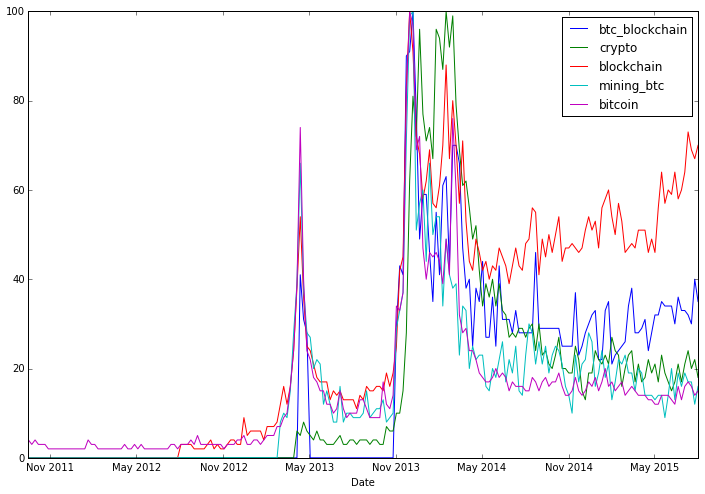

In [14]:
_ = clean_term_data[['btc_blockchain', 'crypto', 'blockchain', 'mining_btc', 'bitcoin']].plot(figsize=(12,8));

In [15]:
# GENERATING ORDER SIGNALS

# the simple strategy here: decide whether there is enough movement in the volume of searches for the term to go and
# execute a trade in the market that will make a profit

# the paper, Preis et al, 2013, defines this threshold as: if there is a higher search volume at the end of a Google
# trends week than in the previous three-week averge of the search volume, then we will go short
# if there is a decline, we will go long the following week

# discuss why this was problematic

In [16]:
# New data frame with columns that had the highest correlations (>0.8) to Close price
highest_corr_terms_and_close = clean_term_data[['btc_blockchain', 'crypto', 'mining_btc', 'bitcoin', 'blockchain', \
                                                'Close']].copy()

            btc_blockchain   Close  signal0   PctChg  return0  cumret0
Date                                                                  
2011-09-17               0    4.87        0  0.16632  0.00000  0.00000
2011-09-24               0    5.68        0 -0.29754 -0.00000  0.00000
2011-10-08               0    3.99        0 -0.01003 -0.00000  0.00000
2011-10-29               0    3.95        0 -0.24051 -0.00000  0.00000
2011-11-05               0    3.00        0  0.11667  0.00000  0.00000
...                    ...     ...      ...      ...      ...      ...
2015-07-04              33  260.20        0  0.12083  0.00000  2.64375
2015-07-11              32  291.64       -1 -0.05092  0.05092  2.82929
2015-07-18              30  276.79       -1  0.04332 -0.04332  2.66341
2015-07-25              40  288.78        1 -0.02975 -0.02975  2.55444
2015-08-01              35  280.19        1      NaN      NaN      NaN

[199 rows x 6 columns]

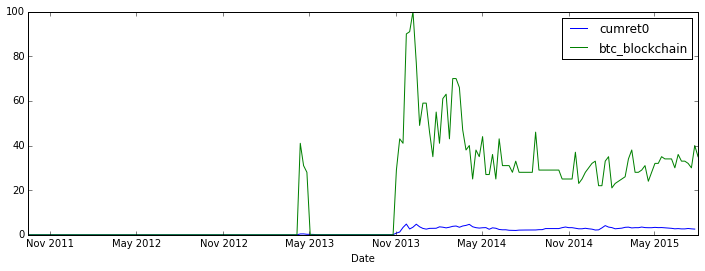

In [17]:
# Create a new base dataframe
btc_blockchain_base = highest_corr_terms_and_close[['btc_blockchain', 'Close']].copy()
# calculate the moving average of the previous three weeks for each week
btc_blockchain_base['OMA'] = pd.rolling_mean(btc_blockchain_base.btc_blockchain.shift(1), 3)

def add_base(term):
    string_name = term + '_base'
    return string_name

def quantified_trend_return(search_term):
    # create new base dataframe
    base_df_name = add_base(search_term)
    base_df_name = highest_corr_terms_and_close[[search_term, 'Close']].copy()
    
    # DECISION ON INFORMATION
    base_df_name['signal0'] = 0
    base_df_name.loc[base_df_name[search_term] > btc_blockchain_base.OMA, 'signal0'] = 1
    base_df_name.loc[base_df_name[search_term] < btc_blockchain_base.OMA, 'signal0'] = -1
    
    # COMPUTING RETURNS
    base_df_name = base_df_name[base_df_name.Close != 0.00].copy()
    base_df_name['PctChg'] = base_df_name.Close.pct_change().shift(-1)
    
    base_df_name['return0'] = base_df_name.PctChg * base_df_name.signal0
    base_df_name['cumret0'] = (1 + base_df_name.return0).cumprod() - 1
    base_df_name[['cumret0', search_term]].plot(figsize=(12,4));
    return base_df_name

quantified_trend_return('btc_blockchain')

In [18]:
# market microstructure is important.. 

# show slide of market microstructure

In [19]:
#start = combined_data_frame.index.searchsorted(dt.date(2011, 9, 13))
#end = combined_data_frame.index.searchsorted(dt.date(2015, 8, 9))
total_bitcoin = Quandl.get("BCHAIN/TOTBC")

In [20]:
total_btc = total_bitcoin.copy()
total_btc['weighted_price'] = btc_bitstamp[['Weighted Price']]
total_btc_clean = total_btc.dropna()
total_btc_clean

               Value  weighted_price
Date                                
2011-09-13   7259900         5.92923
2011-09-14   7267500         5.59080
2011-09-15   7274900         5.09427
2011-09-16   7281200         4.85452
2011-09-17   7287350         4.87000
...              ...             ...
2015-09-25  14652725       235.19176
2015-09-26  14656525       234.34147
2015-09-27  14660125       232.56174
2015-09-28  14663600       237.30590
2015-09-29  14672275       237.64409

[1478 rows x 2 columns]

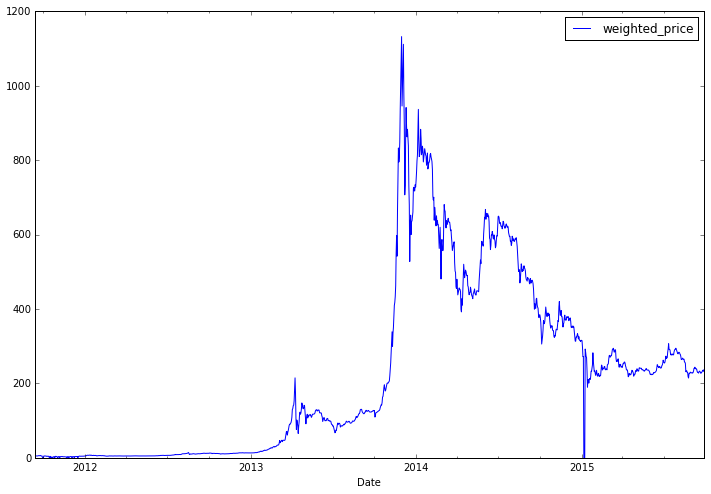

In [21]:
total_btc_clean[['weighted_price']].plot(figsize=(12,8));

In [22]:
btc_300_mask = total_btc_clean[total_btc_clean.weighted_price < 300].copy()

In [23]:
btc_300_mask = btc_300_mask[btc_300_mask.weighted_price != 0.0].copy()

In [24]:
# Accounting for the spike in awareness and valuation bubble, the value of bitcoin has a 0.92 correlation with the 
# number of bitcoin in circulation
btc_300_mask.columns = ['total_btc', 'weighted_price']
btc_300_mask.corr()

                total_btc  weighted_price
total_btc         1.00000         0.92841
weighted_price    0.92841         1.00000

In [25]:
btc_300_mask['scaled_total_btc'] = btc_300_mask['total_btc'] / 10000.0
btc_300_mask

            total_btc  weighted_price  scaled_total_btc
Date                                                   
2011-09-13    7259900         5.92923          725.9900
2011-09-14    7267500         5.59080          726.7500
2011-09-15    7274900         5.09427          727.4900
2011-09-16    7281200         4.85452          728.1200
2011-09-17    7287350         4.87000          728.7350
...               ...             ...               ...
2015-09-25   14652725       235.19176         1465.2725
2015-09-26   14656525       234.34147         1465.6525
2015-09-27   14660125       232.56174         1466.0125
2015-09-28   14663600       237.30590         1466.3600
2015-09-29   14672275       237.64409         1467.2275

[1036 rows x 3 columns]

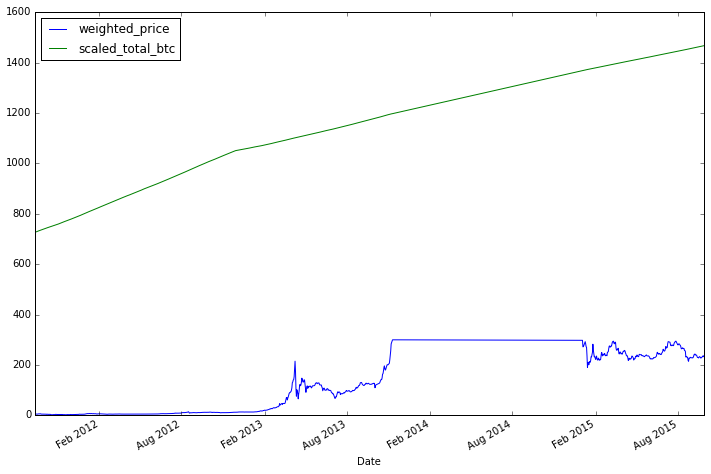

In [26]:
btc_300_mask[['weighted_price', 'scaled_total_btc']].plot(figsize=(12,8));

            btc_blockchain   Close  signal0   PctChg  return0  cumret0
Date                                                                  
2011-09-17               0    4.87        0  0.16632  0.00000  0.00000
2011-09-24               0    5.68        0 -0.29754 -0.00000  0.00000
2011-10-08               0    3.99        0 -0.01003 -0.00000  0.00000
2011-10-29               0    3.95        0 -0.24051 -0.00000  0.00000
2011-11-05               0    3.00        0  0.11667  0.00000  0.00000
...                    ...     ...      ...      ...      ...      ...
2015-07-04              33  260.20        0  0.12083  0.00000  2.64375
2015-07-11              32  291.64       -1 -0.05092  0.05092  2.82929
2015-07-18              30  276.79       -1  0.04332 -0.04332  2.66341
2015-07-25              40  288.78        1 -0.02975 -0.02975  2.55444
2015-08-01              35  280.19        1      NaN      NaN      NaN

[199 rows x 6 columns]

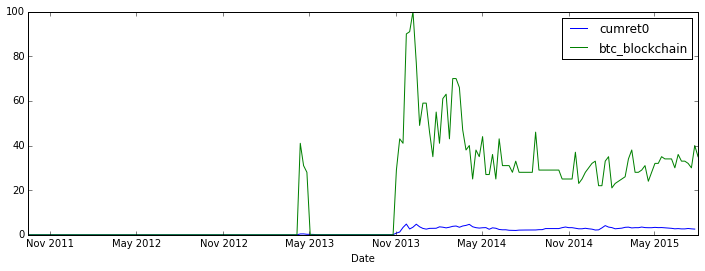

In [27]:
quantified_trend_return('btc_blockchain')

            crypto   Close  signal0   PctChg  return0  cumret0
Date                                                          
2011-09-17       0    4.87        0  0.16632  0.00000  0.00000
2011-09-24       0    5.68        0 -0.29754 -0.00000  0.00000
2011-10-08       0    3.99        0 -0.01003 -0.00000  0.00000
2011-10-29       0    3.95        0 -0.24051 -0.00000  0.00000
2011-11-05       0    3.00        0  0.11667  0.00000  0.00000
...            ...     ...      ...      ...      ...      ...
2015-07-04      21  260.20       -1  0.12083 -0.12083 -0.80826
2015-07-11      24  291.64       -1 -0.05092  0.05092 -0.79850
2015-07-18      20  276.79       -1  0.04332 -0.04332 -0.80723
2015-07-25      22  288.78       -1 -0.02975  0.02975 -0.80149
2015-08-01      18  280.19       -1      NaN      NaN      NaN

[199 rows x 6 columns]

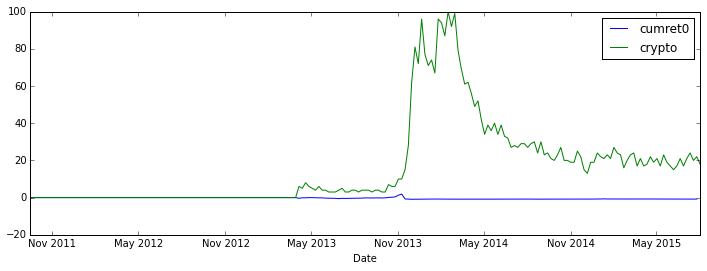

In [28]:
quantified_trend_return('crypto')

            mining_btc   Close  signal0   PctChg  return0   cumret0
Date                                                               
2011-09-17           0    4.87        0  0.16632  0.00000   0.00000
2011-09-24           0    5.68        0 -0.29754 -0.00000   0.00000
2011-10-08           0    3.99        0 -0.01003 -0.00000   0.00000
2011-10-29           0    3.95        0 -0.24051 -0.00000   0.00000
2011-11-05           0    3.00        0  0.11667  0.00000   0.00000
...                ...     ...      ...      ...      ...       ...
2015-07-04          19  260.20       -1  0.12083 -0.12083  11.88259
2015-07-11          17  291.64       -1 -0.05092  0.05092  12.53856
2015-07-18          17  276.79       -1  0.04332 -0.04332  11.95209
2015-07-25          12  288.78       -1 -0.02975  0.02975  12.33736
2015-08-01          16  280.19       -1      NaN      NaN       NaN

[199 rows x 6 columns]

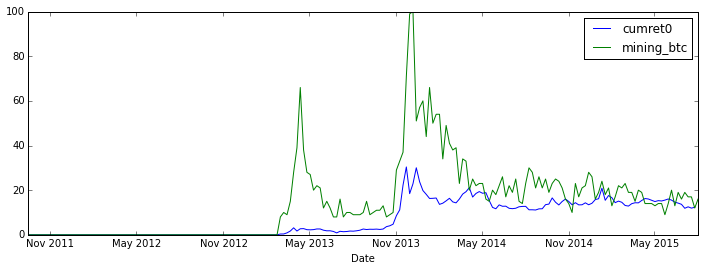

In [29]:
#btc_blockchain', 'crypto', 'mining_btc', 'bitcoin', 'blockchain'
quantified_trend_return('mining_btc')

            bitcoin   Close  signal0   PctChg  return0    cumret0
Date                                                             
2011-09-17        4    4.87        0  0.16632  0.00000    0.00000
2011-09-24        3    5.68        0 -0.29754 -0.00000    0.00000
2011-10-08        3    3.99        1 -0.01003 -0.01003   -0.01003
2011-10-29        2    3.95        1 -0.24051 -0.24051   -0.24812
2011-11-05        2    3.00        1  0.11667  0.11667   -0.16040
...             ...     ...      ...      ...      ...        ...
2015-07-04       16  260.20       -1  0.12083 -0.12083  368.15628
2015-07-11       17  291.64       -1 -0.05092  0.05092  386.95332
2015-07-18       16  276.79       -1  0.04332 -0.04332  370.14795
2015-07-25       14  288.78       -1 -0.02975  0.02975  381.18805
2015-08-01       15  280.19       -1      NaN      NaN        NaN

[199 rows x 6 columns]

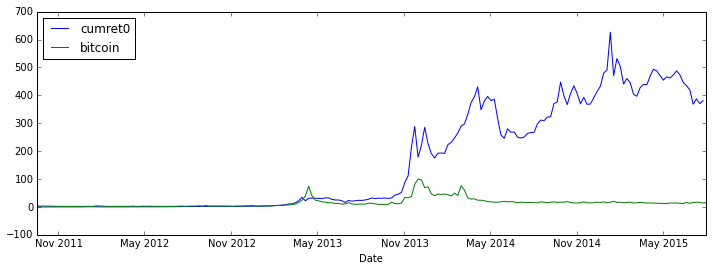

In [30]:
quantified_trend_return('bitcoin')

            blockchain   Close  signal0   PctChg  return0   cumret0
Date                                                               
2011-09-17           0    4.87        0  0.16632  0.00000   0.00000
2011-09-24           0    5.68        0 -0.29754 -0.00000   0.00000
2011-10-08           0    3.99        0 -0.01003 -0.00000   0.00000
2011-10-29           0    3.95        0 -0.24051 -0.00000   0.00000
2011-11-05           0    3.00        0  0.11667  0.00000   0.00000
...                ...     ...      ...      ...      ...       ...
2015-07-04          64  260.20        1  0.12083  0.12083  38.90935
2015-07-11          73  291.64        1 -0.05092 -0.05092  36.87721
2015-07-18          69  276.79        1  0.04332  0.04332  38.51798
2015-07-25          67  288.78        1 -0.02975 -0.02975  37.34248
2015-08-01          70  280.19        1      NaN      NaN       NaN

[199 rows x 6 columns]

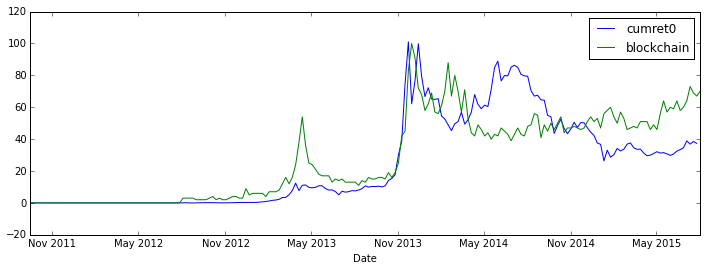

In [31]:
quantified_trend_return('blockchain')

In [32]:
data_09_11 = pd.read_json('http://stats.grok.se/json/en/201109/bitcoin', typ='frame')
data_10_11 = pd.read_json('http://stats.grok.se/json/en/201110/bitcoin', typ='frame')
data_11_11 = pd.read_json('http://stats.grok.se/json/en/201111/bitcoin', typ='frame')
data_12_11 = pd.read_json('http://stats.grok.se/json/en/201211/bitcoin', typ='frame')

data_01_12 = pd.read_json('http://stats.grok.se/json/en/201201/bitcoin', typ='frame')
data_02_12 = pd.read_json('http://stats.grok.se/json/en/201202/bitcoin', typ='frame')
data_03_12 = pd.read_json('http://stats.grok.se/json/en/201203/bitcoin', typ='frame')
data_04_12 = pd.read_json('http://stats.grok.se/json/en/201204/bitcoin', typ='frame')
data_05_12 = pd.read_json('http://stats.grok.se/json/en/201205/bitcoin', typ='frame')
data_06_12 = pd.read_json('http://stats.grok.se/json/en/201206/bitcoin', typ='frame')
data_07_12 = pd.read_json('http://stats.grok.se/json/en/201207/bitcoin', typ='frame')
data_08_12 = pd.read_json('http://stats.grok.se/json/en/201208/bitcoin', typ='frame')
data_09_12 = pd.read_json('http://stats.grok.se/json/en/201209/bitcoin', typ='frame')
data_10_12 = pd.read_json('http://stats.grok.se/json/en/201210/bitcoin', typ='frame')
data_11_12 = pd.read_json('http://stats.grok.se/json/en/201211/bitcoin', typ='frame')
data_12_12 = pd.read_json('http://stats.grok.se/json/en/201212/bitcoin', typ='frame')


data_01_13 = pd.read_json('http://stats.grok.se/json/en/201301/bitcoin', typ='frame')
data_02_13 = pd.read_json('http://stats.grok.se/json/en/201302/bitcoin', typ='frame')
data_03_13 = pd.read_json('http://stats.grok.se/json/en/201303/bitcoin', typ='frame')
data_04_13 = pd.read_json('http://stats.grok.se/json/en/201304/bitcoin', typ='frame')
data_05_13 = pd.read_json('http://stats.grok.se/json/en/201305/bitcoin', typ='frame')
data_06_13 = pd.read_json('http://stats.grok.se/json/en/201306/bitcoin', typ='frame')
data_07_13 = pd.read_json('http://stats.grok.se/json/en/201307/bitcoin', typ='frame')
data_08_13 = pd.read_json('http://stats.grok.se/json/en/201308/bitcoin', typ='frame')
data_09_13 = pd.read_json('http://stats.grok.se/json/en/201309/bitcoin', typ='frame')
data_10_13 = pd.read_json('http://stats.grok.se/json/en/201310/bitcoin', typ='frame')
data_11_13 = pd.read_json('http://stats.grok.se/json/en/201311/bitcoin', typ='frame')
data_12_13 = pd.read_json('http://stats.grok.se/json/en/201312/bitcoin', typ='frame')

data_01_14 = pd.read_json('http://stats.grok.se/json/en/201401/bitcoin', typ='frame')
data_02_14 = pd.read_json('http://stats.grok.se/json/en/201402/bitcoin', typ='frame')
data_03_14 = pd.read_json('http://stats.grok.se/json/en/201403/bitcoin', typ='frame')
data_04_14 = pd.read_json('http://stats.grok.se/json/en/201404/bitcoin', typ='frame')
data_05_14 = pd.read_json('http://stats.grok.se/json/en/201405/bitcoin', typ='frame')
data_06_14 = pd.read_json('http://stats.grok.se/json/en/201406/bitcoin', typ='frame')
data_07_14 = pd.read_json('http://stats.grok.se/json/en/201407/bitcoin', typ='frame')
data_08_14 = pd.read_json('http://stats.grok.se/json/en/201408/bitcoin', typ='frame')
data_09_14 = pd.read_json('http://stats.grok.se/json/en/201409/bitcoin', typ='frame')
data_10_14 = pd.read_json('http://stats.grok.se/json/en/201410/bitcoin', typ='frame')
data_11_14 = pd.read_json('http://stats.grok.se/json/en/201411/bitcoin', typ='frame')
data_12_14 = pd.read_json('http://stats.grok.se/json/en/201412/bitcoin', typ='frame')


data_01_15 = pd.read_json('http://stats.grok.se/json/en/201501/bitcoin', typ='frame')
data_02_15 = pd.read_json('http://stats.grok.se/json/en/201502/bitcoin', typ='frame')
data_03_15 = pd.read_json('http://stats.grok.se/json/en/201503/bitcoin', typ='frame')
data_04_15 = pd.read_json('http://stats.grok.se/json/en/201504/bitcoin', typ='frame')
data_05_15 = pd.read_json('http://stats.grok.se/json/en/201505/bitcoin', typ='frame')
data_06_15 = pd.read_json('http://stats.grok.se/json/en/201506/bitcoin', typ='frame')
data_07_15 = pd.read_json('http://stats.grok.se/json/en/201507/bitcoin', typ='frame')
data_08_15 = pd.read_json('http://stats.grok.se/json/en/201508/bitcoin', typ='frame')

In [33]:
new_frame = [data_09_11, data_10_11, data_11_11, data_12_11, data_01_12, data_02_12, \
             data_03_12, data_04_12, data_05_12, data_06_12, data_07_12, data_08_12, \
             data_09_12, data_10_12, data_11_12, data_12_12, data_01_13, data_02_13, \
             data_03_13, data_04_13, data_05_13, data_06_13, data_07_13, data_08_13, \
             data_09_13, data_10_13, data_11_13, data_12_13, data_01_14, data_02_14, \
             data_03_14, data_04_14, data_05_14, data_06_14, data_07_14, data_08_14, \
             data_09_14, data_10_14, data_11_14, data_12_14, data_01_15, data_02_15, \
             data_03_15, data_04_15, data_05_15, data_06_15, data_07_15, data_08_15]

In [34]:
wikipedia_raw_data = pd.concat(new_frame)
new_wiki = wikipedia_raw_data.reset_index()
new_wiki.columns = ['Date', 'daily_views', 'month', 'project', 'rank', 'title']

wiki_data = new_wiki[['Date', 'daily_views', 'title']]
wiki_data[:5]
wiki_data = wiki_data.set_index(wiki_data['Date'], drop=True)

wiki_data = wiki_data[['daily_views', 'title']]
wiki_data.index = pd.to_datetime(wiki_data.index)

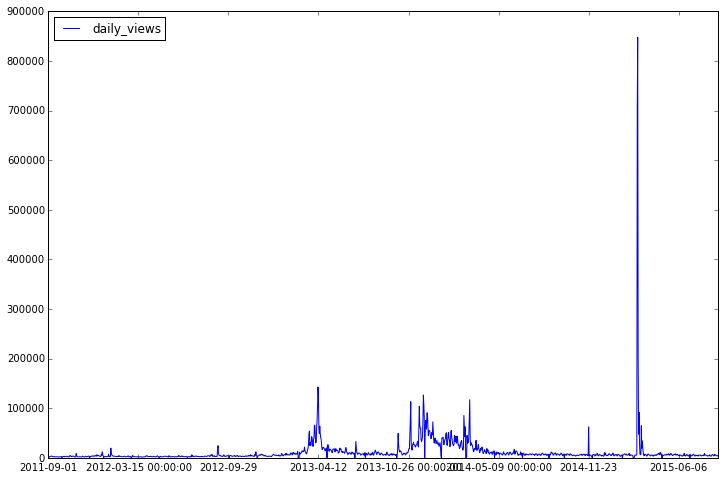

In [35]:
wiki_data.plot(figsize=(12,8));

In [36]:
wiki_data[wiki_data.daily_views > 200000]

                     daily_views    title
2015-03-07 00:00:00       704362  bitcoin
2015-03-08 00:00:00       847614  bitcoin

In [37]:
wiki_data.daily_views.max()

847614

In [38]:
# the aggressive spike on March 7-8, 2015 appears related to the handing down of the verdict in the trial of
# Ross Ulbricht, Silk Road mastermind
# http://arstechnica.com/tech-policy/2015/03/convicted-silk-road-mastermind-ross-ulbricht-demands-trial-do-over/
# http://gizmodo.com/the-silk-road-mastermind-just-applied-for-a-retrial-1690090816

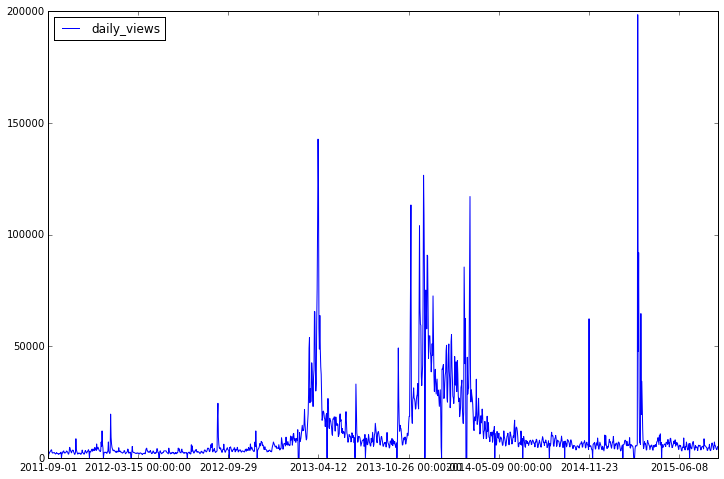

In [39]:
wiki_data[wiki_data.daily_views < 200000].plot(figsize=(12,8));

In [40]:
new_test = wiki_data.copy()
new_test = new_test.reset_index()
new_test.columns = ['Date', 'daily_views', 'title']
dti = pd.to_datetime(new_test.Date)
new_test

                     Date  daily_views    title
0              2011-09-01         3105  bitcoin
1              2011-09-02            0  bitcoin
2              2011-09-03         2089  bitcoin
3              2011-09-04         2068  bitcoin
4              2011-09-05         2439  bitcoin
...                   ...          ...      ...
1483  2015-08-27 00:00:00         4778  bitcoin
1484  2015-08-28 00:00:00         4110  bitcoin
1485  2015-08-29 00:00:00         3647  bitcoin
1486  2015-08-30 00:00:00         3810  bitcoin
1487  2015-08-31 00:00:00         4987  bitcoin

[1488 rows x 3 columns]

In [41]:
new_df = pd.date_range('2011-09-01', '2015-08-09', freq='D')
df = pd.DataFrame

In [42]:
wiki_df = pd.DataFrame(np.arange(1, 1440))

In [43]:
wiki_df = pd.DataFrame(np.arange(1, 1440))
wiki_df['daily_views'] = new_test[['daily_views']]
daily_v_series = new_test[['daily_views']].copy()
new_ser = pd.Series(daily_v_series['daily_views'])

In [44]:
wiki_df['daily_views'] = new_ser

In [45]:
wiki_df.insert(1, 'Dates', pd.DatetimeIndex(pd.date_range('2011-09-01', '2015-08-09', freq='D')).date)

In [46]:
wiki_df

         0       Dates  daily_views
0        1  2011-09-01         3105
1        2  2011-09-02            0
2        3  2011-09-03         2089
3        4  2011-09-04         2068
4        5  2011-09-05         2439
...    ...         ...          ...
1434  1435  2015-08-05         6057
1435  1436  2015-08-06         4956
1436  1437  2015-08-07         3424
1437  1438  2015-08-08         3726
1438  1439  2015-08-09         5501

[1439 rows x 3 columns]

In [47]:
wiki_df = wiki_df[['Dates', 'daily_views']]
wiki_df

           Dates  daily_views
0     2011-09-01         3105
1     2011-09-02            0
2     2011-09-03         2089
3     2011-09-04         2068
4     2011-09-05         2439
...          ...          ...
1434  2015-08-05         6057
1435  2015-08-06         4956
1436  2015-08-07         3424
1437  2015-08-08         3726
1438  2015-08-09         5501

[1439 rows x 2 columns]

In [48]:
test_wiki = wiki_df.copy()

In [49]:
wiki_date_index = test_wiki.set_index(test_wiki['Dates'], drop=True)

In [50]:
wiki_date_index.drop('Dates', axis=1, inplace=True)

In [51]:
wiki_date_index

            daily_views
Dates                  
2011-09-01         3105
2011-09-02            0
2011-09-03         2089
2011-09-04         2068
2011-09-05         2439
...                 ...
2015-08-05         6057
2015-08-06         4956
2015-08-07         3424
2015-08-08         3726
2015-08-09         5501

[1439 rows x 1 columns]

In [52]:
the_wiki_btc_df = wiki_date_index.copy()

In [53]:
the_wiki_btc_df['btc_search_index'] = bitcoin_term['bitcoin']

In [54]:
the_wiki_btc_df

            daily_views  btc_search_index
Dates                                    
2011-09-01         3105               NaN
2011-09-02            0               NaN
2011-09-03         2089                 5
2011-09-04         2068               NaN
2011-09-05         2439               NaN
...                 ...               ...
2015-08-05         6057               NaN
2015-08-06         4956               NaN
2015-08-07         3424               NaN
2015-08-08         3726               NaN
2015-08-09         5501               NaN

[1439 rows x 2 columns]

In [55]:
wiki_btc_close = wiki_date_index.copy()
wiki_btc_close['btc_close'] = btc_bitstamp['Close']

In [56]:
wiki_btc_close = wiki_btc_close.dropna()

In [57]:
wiki_btc_close

wiki_plot = wiki_btc_close[wiki_btc_close.daily_views < 150000]
wiki_plot

            daily_views  btc_close
Dates                             
2011-09-13         2228       5.97
2011-09-14         2328       5.53
2011-09-15         2387       5.13
2011-09-16         2051       4.85
2011-09-17         1839       4.87
...                 ...        ...
2015-08-05         6057     281.99
2015-08-06         4956     277.61
2015-08-07         3424     279.54
2015-08-08         3726     266.94
2015-08-09         5501     264.56

[1424 rows x 2 columns]

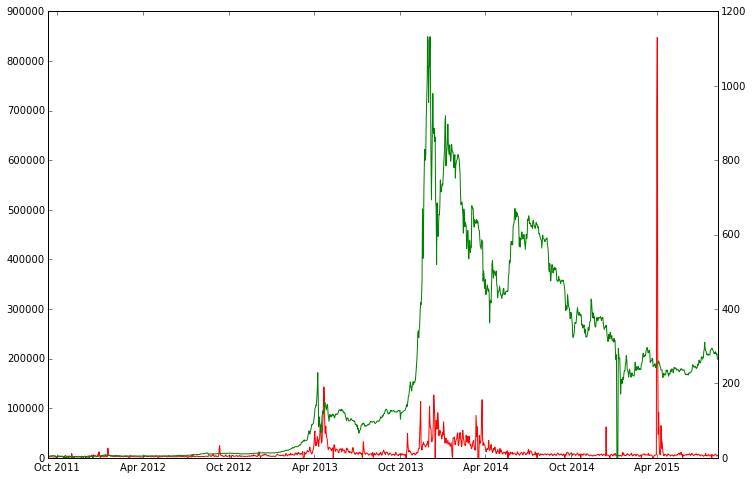

In [58]:
"""
FIGURE 2: Wikipedia Daily Views vs BTC Close
"""

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(wiki_btc_close.index,
         wiki_btc_close.daily_views, color='r')
ax2 = ax1.twinx()
ax2.plot(wiki_btc_close.index,
         wiki_btc_close.btc_close, color='g')
plt.show()

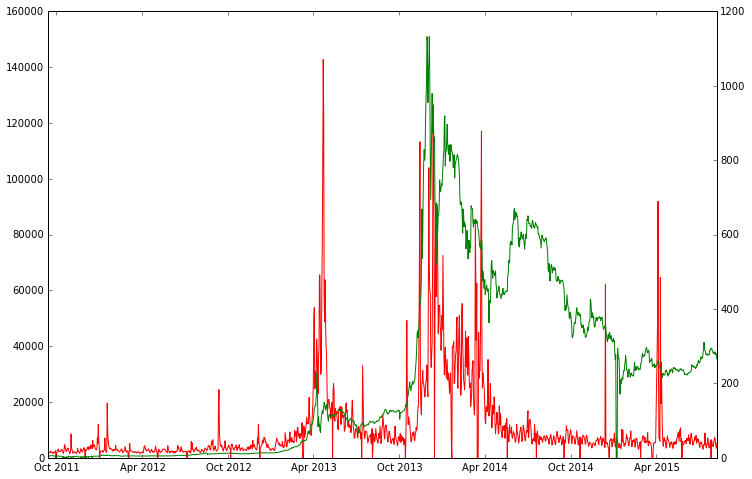

In [59]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(wiki_plot.index,
         wiki_plot.daily_views, color='r')
ax2 = ax1.twinx()
ax2.plot(wiki_plot.index,
         wiki_plot.btc_close, color='g')
plt.show()

In [60]:
wiki_btc_close

            daily_views  btc_close
Dates                             
2011-09-13         2228       5.97
2011-09-14         2328       5.53
2011-09-15         2387       5.13
2011-09-16         2051       4.85
2011-09-17         1839       4.87
...                 ...        ...
2015-08-05         6057     281.99
2015-08-06         4956     277.61
2015-08-07         3424     279.54
2015-08-08         3726     266.94
2015-08-09         5501     264.56

[1427 rows x 2 columns]

In [61]:
mdata = wiki_btc_close.copy()
#mdata['bitcoin_index'] = bitcoin_term['bitcoin']
mdata = mdata.reset_index()

# prepare the dates index
mdata.insert(1, 'Date', pd.DatetimeIndex(mdata['Dates']))

#mdata = mdata[['Date', 'daily_views', 'btc_close']]
mdata.index = pd.DatetimeIndex(mdata['Date'])

mdata.drop('Dates', axis=1, inplace=True)
mdata.drop('Date', axis=1, inplace=True)
mdata


data = np.log(mdata).diff().dropna()
data
new_data = data.replace([np.inf, -np.inf], np.nan)
new_data = new_data.dropna()
new_data

            daily_views  btc_close
2011-09-14      0.04391   -0.07656
2011-09-15      0.02503   -0.07508
2011-09-16     -0.15171   -0.05613
2011-09-17     -0.10911    0.00412
2011-09-18     -0.08746    0.01021
...                 ...        ...
2015-08-05     -0.18337   -0.01062
2015-08-06     -0.20062   -0.01565
2015-08-07     -0.36979    0.00693
2015-08-08      0.08453   -0.04612
2015-08-09      0.38959   -0.00896

[1336 rows x 2 columns]

In [62]:
# make a VAR model
model = tpi.VAR(new_data)

In [63]:
results = model.fit(2)

In [64]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Sep, 2015
Time:                     08:29:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.86726
Nobs:                     1334.00    HQIC:                  -7.89162
Log likelihood:           1497.72    FPE:                0.000368447
AIC:                     -7.90621    Det(Omega_mle):     0.000365700
--------------------------------------------------------------------
Results for equation daily_views
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.001164         0.009251           -0.126           0.900
L1.daily_views        -0.066073         0.027033           -2.444           0.015
L1.btc_close          -0.192077         0.162528  

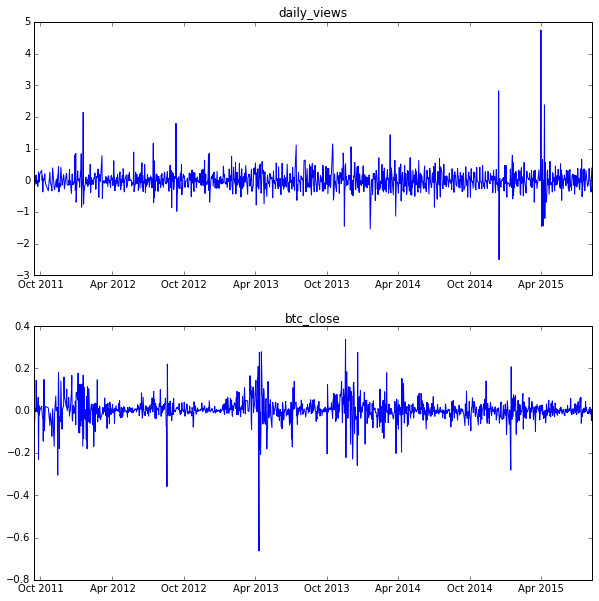

In [65]:
results.plot()

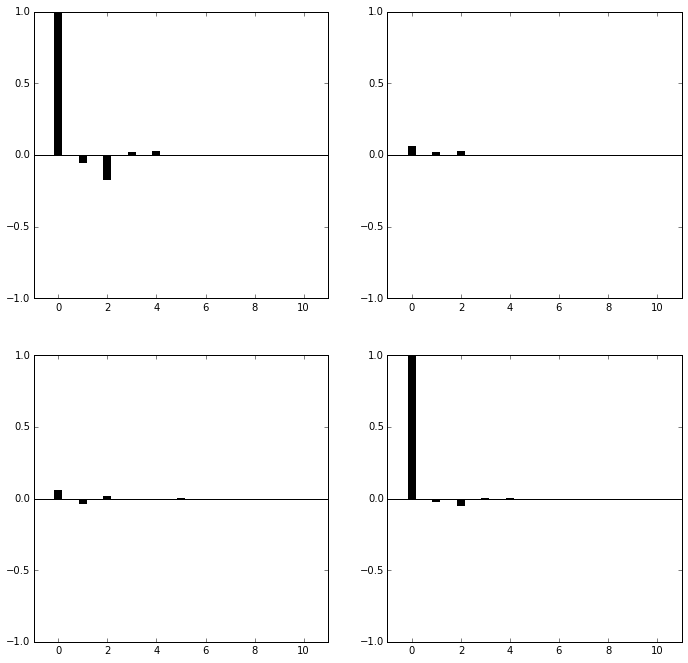

In [66]:
results.plot_acorr()

In [67]:
model.select_order(5)

                 VAR Order Selection                 
           aic          bic          fpe         hqic
-----------------------------------------------------
0       -7.871       -7.863    0.0003816       -7.868
1       -7.871       -7.848    0.0003816       -7.862
2       -7.903       -7.864    0.0003697       -7.888
3       -7.930       -7.875    0.0003599       -7.909
4       -7.947       -7.877    0.0003538       -7.921
5      -7.981*      -7.896*   0.0003418*      -7.949*
* Minimum



{'aic': 5, 'bic': 5, 'fpe': 5, 'hqic': 5}

In [68]:
results = model.fit(maxlags=15, ic='aic')

In [69]:
# the linear predictor is the optimal h-step ahead forecast in terms of mean-squared error:

lag_order = results.k_ar
results.forecast(new_data.values[-lag_order:], 5)

array([[ 0.09362384,  0.0020801 ],
       [-0.01193597,  0.00037011],
       [-0.09623862, -0.00142503],
       [-0.07961179, -0.00569838],
       [-0.11656472, -0.0037872 ]])

In [70]:
irf = results.irf(10)

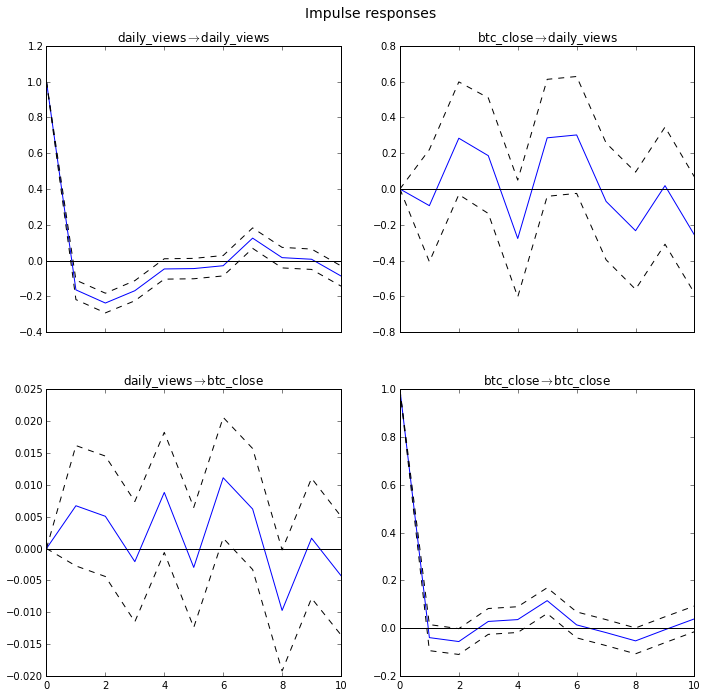

In [71]:
irf.plot(orth=False)

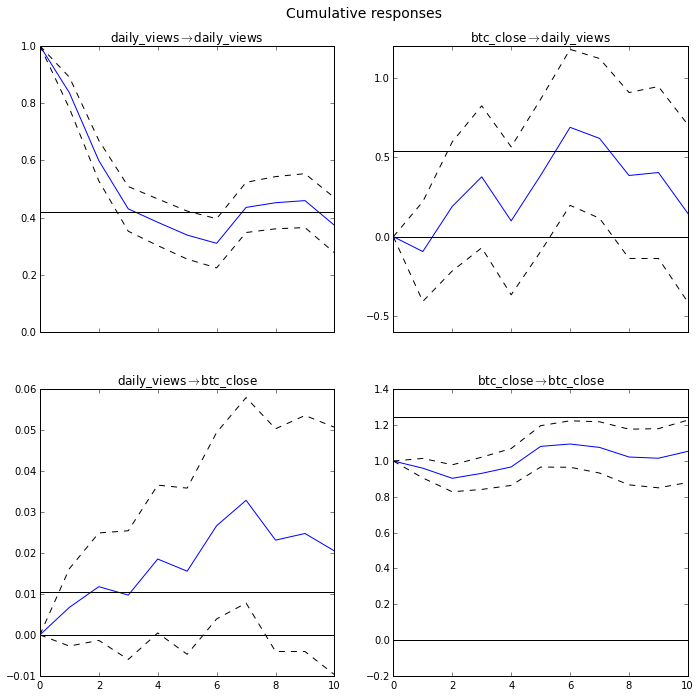

In [72]:
irf.plot_cum_effects(orth=False)

In [73]:
fevd = results.fevd(5)

In [74]:
fevd.summary()

FEVD for daily_views
     daily_views  btc_close
0       1.000000   0.000000
1       0.999745   0.000255
2       0.997522   0.002478
3       0.996648   0.003352
4       0.994597   0.005403

FEVD for btc_close
     daily_views  btc_close
0       0.005526   0.994474
1       0.006777   0.993223
2       0.007367   0.992633
3       0.007456   0.992544
4       0.010231   0.989769




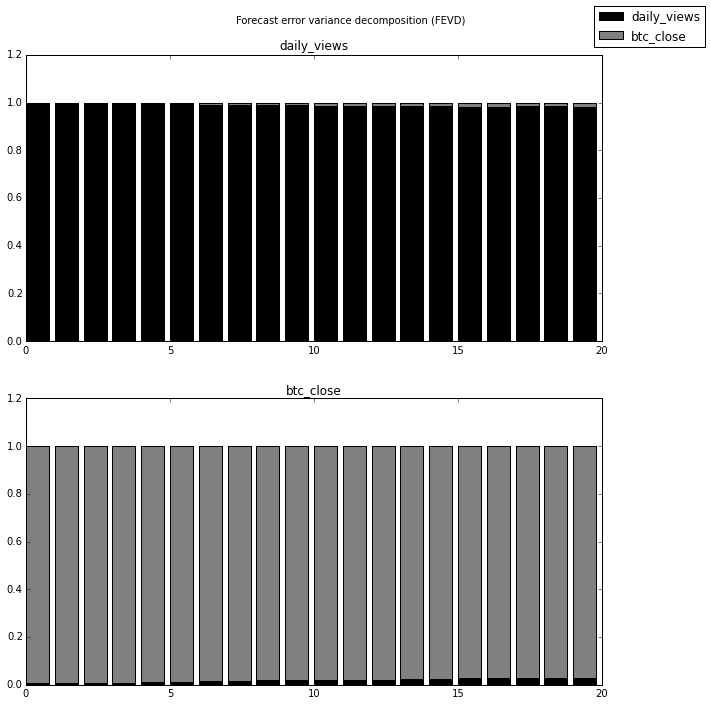

In [75]:
results.fevd(20).plot()

In [76]:
results.test_causality('btc_close', ['daily_views'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value          df
---------------------------------------------------------------
         2.157407         1.695595            0.007  (14, 2586)
H_0: ['daily_views'] do not Granger-cause btc_close
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 1.695594757637003,
 'df': (14, 2586),
 'pvalue': 0.0073976616911838617,
 'signif': 0.05,
 'statistic': 2.1574065915620637}

In [77]:
highest_corr_terms_and_close

            btc_blockchain  crypto  mining_btc  bitcoin  blockchain   Close
Date                                                                       
2011-09-17               0       0           0        4           0    4.87
2011-09-24               0       0           0        3           0    5.68
2011-10-01               0       0           0        4           0    0.00
2011-10-08               0       0           0        3           0    3.99
2011-10-15               0       0           0        3           0    0.00
...                    ...     ...         ...      ...         ...     ...
2015-07-04              33      21          19       16          64  260.20
2015-07-11              32      24          17       17          73  291.64
2015-07-18              30      20          17       16          69  276.79
2015-07-25              40      22          12       14          67  288.78
2015-08-01              35      18          16       15          70  280.19

[203 rows x

In [78]:
wiki_plot

            daily_views  btc_close
Dates                             
2011-09-13         2228       5.97
2011-09-14         2328       5.53
2011-09-15         2387       5.13
2011-09-16         2051       4.85
2011-09-17         1839       4.87
...                 ...        ...
2015-08-05         6057     281.99
2015-08-06         4956     277.61
2015-08-07         3424     279.54
2015-08-08         3726     266.94
2015-08-09         5501     264.56

[1424 rows x 2 columns]

In [79]:
rolling_c = pd.rolling_corr(highest_corr_terms_and_close['bitcoin'], highest_corr_terms_and_close['Close'], window=4).dropna()
rolling_c[3:]

Date
2011-10-29   -0.57152
2011-11-05   -0.98182
2011-11-12   -0.97487
2011-11-19       -inf
2011-11-26       -inf
               ...   
2015-07-04    0.65251
2015-07-11    0.57342
2015-07-18    0.83687
2015-07-25   -0.12168
2015-08-01    0.09546
dtype: float64

In [80]:
new_rolling_c = rolling_c.replace([np.inf, -np.inf], np.nan)
new_rolling_c = new_rolling_c.dropna()
new_rolling_c[3:]

Date
2011-10-29   -0.57152
2011-11-05   -0.98182
2011-11-12   -0.97487
2012-01-21    0.41865
2012-01-28   -0.05300
               ...   
2015-07-04    0.65251
2015-07-11    0.57342
2015-07-18    0.83687
2015-07-25   -0.12168
2015-08-01    0.09546
dtype: float64

In [81]:
#new_rolling_c.plot(figsize=(12,8));

In [82]:
mdata = highest_corr_terms_and_close.copy()
mdata = mdata.reset_index()
mdata
# prepare the dates index
mdata.insert(1, 'Dates', pd.DatetimeIndex(mdata['Date']))

#mdata = mdata[['Date', 'daily_views', 'btc_close']]
mdata.index = pd.DatetimeIndex(mdata['Dates'])

mdata.drop('Dates', axis=1, inplace=True)
mdata.drop('Date', axis=1, inplace=True)
mdata

data = np.log(mdata).diff().dropna()
data
new_data = data.replace([np.inf, -np.inf], np.nan)
new_data = new_data.dropna()
new_data

            btc_blockchain   crypto  mining_btc  bitcoin  blockchain  \
2013-04-20        -0.27958  0.47000    -0.55207 -0.61519    -0.40547   
2013-04-27        -0.10178 -0.28768    -0.30538 -0.51083    -0.36464   
2013-11-09         0.39390  0.00000     0.12921 -0.02985     0.51879   
2013-11-16        -0.04763  0.40547     0.11441  0.11441     0.06899   
2013-11-23         0.78624  0.62415     0.65176  0.78353     0.61218   
...                    ...      ...         ...      ...         ...   
2015-07-04         0.00000  0.21131     0.17185  0.20764     0.06454   
2015-07-11        -0.03077  0.13353    -0.11123  0.06062     0.13158   
2015-07-18        -0.06454 -0.18232     0.00000 -0.06062    -0.05635   
2015-07-25         0.28768  0.09531    -0.34831 -0.13353    -0.02941   
2015-08-01        -0.13353 -0.20067     0.28768  0.06899     0.04380   

              Close  
2013-04-20  0.32277  
2013-04-27  0.01762  
2013-11-09  0.51026  
2013-11-16  0.24168  
2013-11-23  0.64614  
...

In [83]:
model1 = tpi.VAR(new_data)

In [84]:
results = model1.fit(2)

In [85]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Sep, 2015
Time:                     08:29:39
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -19.2347
Nobs:                     91.0000    HQIC:                  -20.5186
Log likelihood:           276.362    FPE:                5.21107e-10
AIC:                     -21.3869    Det(Omega_mle):     2.33871e-10
--------------------------------------------------------------------
Results for equation btc_blockchain
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.001624         0.023090            0.070           0.944
L1.btc_blockchain        -0.546149         0.120755           -4.523           0.000
L1.crypto                -0.181214 

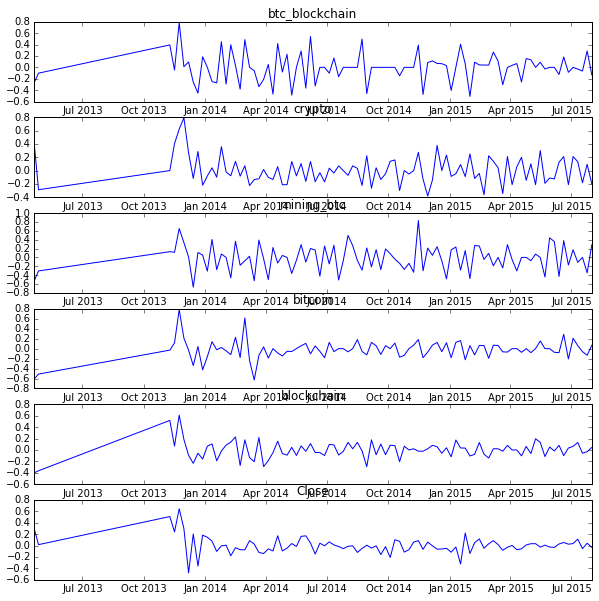

In [86]:
results.plot()

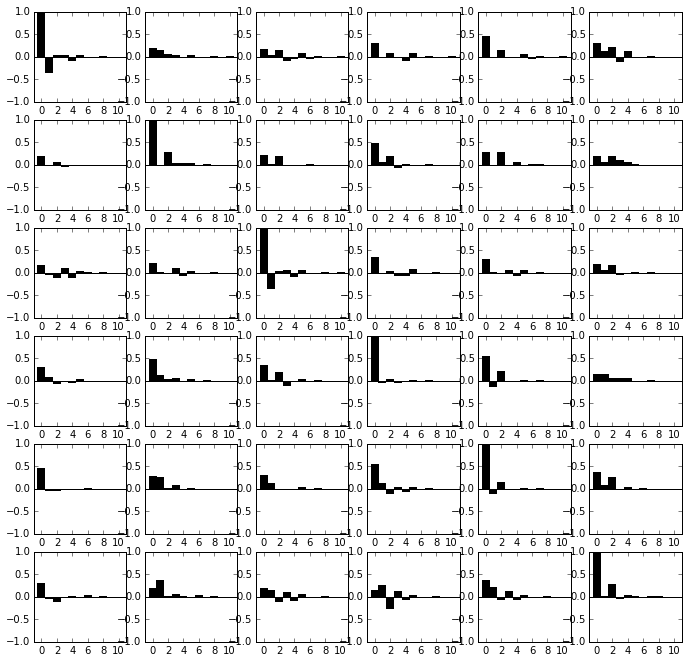

In [87]:
results.plot_acorr()

In [88]:
lag_order = results.k_ar
results.forecast(new_data.values[-lag_order:], 5)

array([[-0.00440668,  0.01336458, -0.15245685, -0.08083658,  0.00118816,
         0.03550569],
       [ 0.06109047,  0.02058426,  0.08441967,  0.05875049,  0.00372741,
        -0.05811894],
       [-0.02626742, -0.02286543, -0.06034248, -0.05324516,  0.00513749,
         0.04049315],
       [-0.0289993 ,  0.0114354 , -0.02796435, -0.00754341, -0.00941446,
        -0.04496565],
       [ 0.0311848 , -0.01372159,  0.01492157, -0.01804512,  0.01331547,
         0.01962786]])

In [89]:
irf = results.irf()

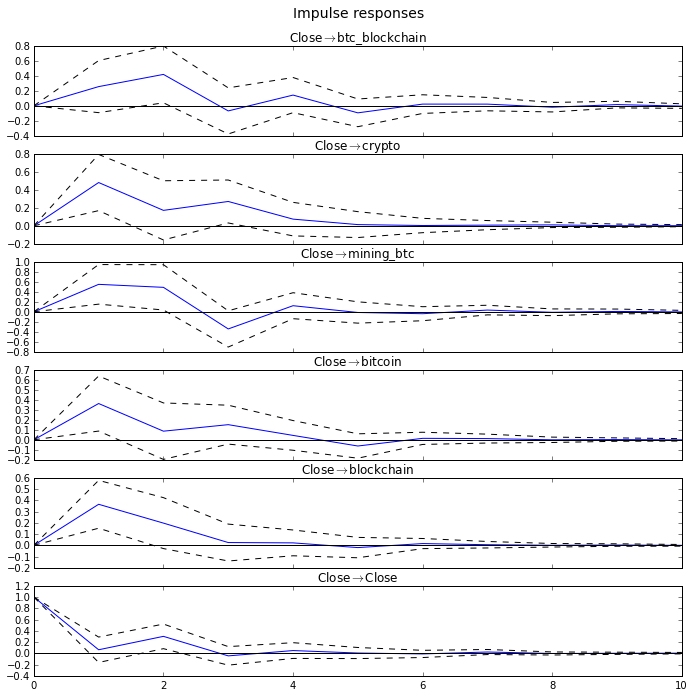

In [90]:
irf.plot(impulse='Close', orth=False)

In [91]:
#raw_columns = ['btc_blockchain', 'crypto', 'mining_btc', 'bitcoin', 'blockchain', 'Close']

#[irf.plot(impulse=x, orth=False) for x in raw_columns]

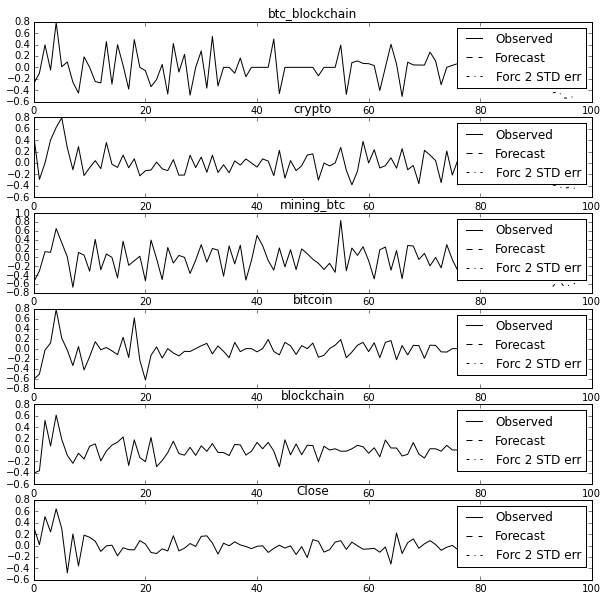

In [92]:
results.plot_forecast(5)

In [93]:
results.test_causality('Close', ['btc_blockchain', 'crypto', 'mining_btc', 'bitcoin', 'blockchain'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.652467         1.850937            0.089  (10, 468)
H_0: ['btc_blockchain', 'crypto', 'mining_btc', 'bitcoin', 'blockchain'] do not Granger-cause Close
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.8509365592312206,
 'df': (10, 468),
 'pvalue': 0.089318072189168207,
 'signif': 0.05,
 'statistic': 1.6524667571605516}

In [94]:
# calculating the expected price
# the algorithm is: 

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

X = btc_300_mask['total_btc']
y = btc_300_mask.weighted_price
xshape = X.shape
yshape = y.shape
X = X.reshape((xshape[0],1))
y = y.reshape((yshape[0],1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("MAE", mean_absolute_error(y_test, y_pred))


MAE 31.6253216146


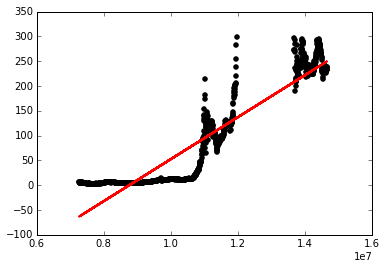

In [95]:
plt.scatter(X, y, color='black')
plt.plot(X_test, regr.predict(X_test), color='red', linewidth=2)
# plt.xticks(())
# plt.yticks(())
plt.show()

In [96]:
btc_bitstamp

              Open    High     Low   Close  Volume (BTC)  Volume (Currency)  \
Date                                                                          
2011-09-13    5.80    6.00    5.65    5.97      58.37138          346.09739   
2011-09-14    5.58    5.72    5.52    5.53      61.14598          341.85481   
2011-09-15    5.12    5.24    5.00    5.13      80.14080          408.25900   
2011-09-16    4.82    4.87    4.80    4.85      39.91401          193.76315   
2011-09-17    4.87    4.87    4.87    4.87       0.30000            1.46100   
...            ...     ...     ...     ...           ...                ...   
2015-09-25  233.88  237.25  232.56  234.39   22325.91895      5250872.18958   
2015-09-26  235.14  235.67  233.00  234.61   14812.16817      3471105.19955   
2015-09-27  233.81  234.61  231.16  232.02   17144.92347      3987253.24273   
2015-09-28  232.40  239.68  231.69  238.85   16549.79447      3927363.85730   
2015-09-29  239.14  240.56  235.09  237.23   19166.1

In [97]:
wiki_btc_close

            daily_views  btc_close
Dates                             
2011-09-13         2228       5.97
2011-09-14         2328       5.53
2011-09-15         2387       5.13
2011-09-16         2051       4.85
2011-09-17         1839       4.87
...                 ...        ...
2015-08-05         6057     281.99
2015-08-06         4956     277.61
2015-08-07         3424     279.54
2015-08-08         3726     266.94
2015-08-09         5501     264.56

[1427 rows x 2 columns]

In [98]:
log_wiki = wiki_btc_close.copy()
log_wiki['log_wiki_views'] = np.log(log_wiki['daily_views'])

In [99]:
log_wiki

            daily_views  btc_close  log_wiki_views
Dates                                             
2011-09-13         2228       5.97         7.70886
2011-09-14         2328       5.53         7.75276
2011-09-15         2387       5.13         7.77779
2011-09-16         2051       4.85         7.62608
2011-09-17         1839       4.87         7.51698
...                 ...        ...             ...
2015-08-05         6057     281.99         8.70897
2015-08-06         4956     277.61         8.50835
2015-08-07         3424     279.54         8.13856
2015-08-08         3726     266.94         8.22309
2015-08-09         5501     264.56         8.61269

[1427 rows x 3 columns]

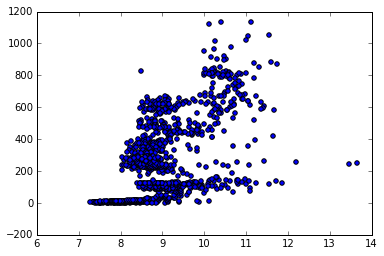

In [100]:
plt.scatter(log_wiki.log_wiki_views, log_wiki.btc_close)

In [101]:
log_wiki[['log_wiki_views', 'btc_close']].corr()

                log_wiki_views  btc_close
log_wiki_views         1.00000    0.63292
btc_close              0.63292    1.00000

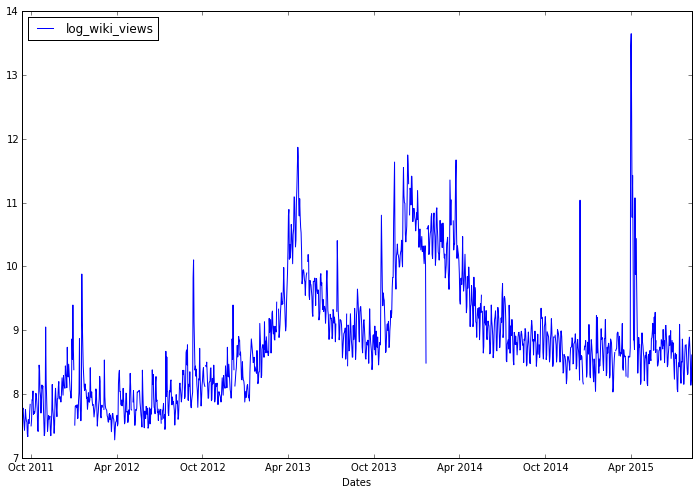

In [102]:
_ = log_wiki[['log_wiki_views']].plot(figsize=(12,8))

In [103]:
btc_bitstamp

              Open    High     Low   Close  Volume (BTC)  Volume (Currency)  \
Date                                                                          
2011-09-13    5.80    6.00    5.65    5.97      58.37138          346.09739   
2011-09-14    5.58    5.72    5.52    5.53      61.14598          341.85481   
2011-09-15    5.12    5.24    5.00    5.13      80.14080          408.25900   
2011-09-16    4.82    4.87    4.80    4.85      39.91401          193.76315   
2011-09-17    4.87    4.87    4.87    4.87       0.30000            1.46100   
...            ...     ...     ...     ...           ...                ...   
2015-09-25  233.88  237.25  232.56  234.39   22325.91895      5250872.18958   
2015-09-26  235.14  235.67  233.00  234.61   14812.16817      3471105.19955   
2015-09-27  233.81  234.61  231.16  232.02   17144.92347      3987253.24273   
2015-09-28  232.40  239.68  231.69  238.85   16549.79447      3927363.85730   
2015-09-29  239.14  240.56  235.09  237.23   19166.1